# INR (Implicit Neural Representations)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/Personal/INR/Playground/Wire Implementation'

Mounted at /content/drive
/content/drive/Shareddrives/Personal/INR/Playground/Wire Implementation


In [ ]:
'''%cd D:/Documents/SEMESTER 8/EE405 - Undergraduate Project/INR/Playground/Wire Implementation'''

'%cd D:/Documents/SEMESTER 8/EE405 - Undergraduate Project/INR/Playground/Wire Implementation'

Importing libraries

In [ ]:
import os
import io
import time

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import io

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

from modules import models, utils

plt.gray()

<Figure size 640x480 with 0 Axes>

## Original Code

Defining parameters

In [ ]:
nonlin = 'wire' # type of nonlinearity, 'wire', 'siren', 'mfn', 'relu', 'posenc', 'gauss'
niters = 2000  # No. of SGD iterations
leaning_rate = 5e-3 # Learning rate

# WIRE works best at 5e-3 to 2e-2, Gauss and SIREN at 1e-3 - 2e-3,
# MFN at 1e-2 - 5e-2, and positional encoding at 5e-4 to 1e-3

tau = 3e1       # Photon noise (max. mean Lambda). Set to 3e7 for representations, 3e1 for denoising
noise_snr = 2   # Readout noise

# # Gaber filter constants
# We suggest omega0 = 4 and sigma0 = 4 for denoising, and omega0=20, sigma0=30 for image representation
omega0 = 5.0
sigma0 = 5.0

# Network parameters
hidden_layers = 2       # No. of hidden layers in the MLP
hidden_features = 256   # Number of hidden layers per layer
maxpoints = 256*256     # Batch size

if torch.cuda.is_available: CUDA = True

Loading image

In [ ]:
# Read image and scale. A scale of 0.5 for parrot image ensures that it fits in a 12GB GPU
im = utils.normalize(x=plt.imread('./images/parrot.png'), fullnormalize=True)
im = cv2.resize(im, None, fx=1/2, fy=1/2, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape
print(f'Image dims: {(H,W)}')

# Adding noise
im_noisy = utils.measure(x=im, noise_snr=noise_snr, tau=tau)

Define model

In [ ]:
if nonlin == 'posenc':
    nonlin = 'relu'
    posencode = True
    if tau<100: sidelength = int(max(H,W)/3)
    else: sidelength = int(max(H,W))
else:
    posencode = False
    sidelength = H

# Initiate model and send to CUDA
model = models.get_INR(
    nonlin=nonlin,
    in_features=2,
    out_features=3,
    hidden_features=hidden_features,
    hidden_layers=hidden_layers,
    first_omega_0=omega0,
    hidden_omega_0=omega0,
    scale=sigma0,
    pos_encode=posencode,
    sidelength=sidelength
)

if CUDA: model.cuda()

print(f'No. of params: {utils.count_parameters(model)}')
print(f'Input PSNR: {utils.psnr(im, im_noisy):.2f}')

Initating optimizer & Lr scheduler

In [ ]:
optim = torch.optim.Adam(
    lr=leaning_rate*min(1, maxpoints/(H*W)),
    params=model.parameters()
    )

scheduler = LambdaLR(
    optimizer=optim,
    lr_lambda=lambda x: 0.1**min(x/niters,1) # 1 --> 0.1
    )

Data preprocessing

In [ ]:
x = torch.linspace(-1, 1, W)
y = torch.linspace(-1, 1, H)

X, Y = torch.meshgrid(x, y, indexing='xy')
coords = torch.hstack((X.reshape(-1,1), Y.reshape(-1,1)))[None, ...]

gt = torch.tensor(im).cuda().reshape(H*W, 3)[None, ...]
gt_noisy = torch.tensor(im_noisy).cuda().reshape(H*W, 3)[None, ...]

Defining loss arrays

In [ ]:
mse_array = torch.zeros(niters, device='cuda')
mse_loss_array = torch.zeros(niters, device='cuda')
time_array = torch.zeros_like(mse_array)

best_mse = torch.tensor(float('inf'))
best_img = None

rec = torch.zeros_like(gt)

Training loop

In [ ]:
from google.colab.patches import cv2_imshow
tbar = tqdm(range(niters))
init_time = time.time()

for epoch in tbar:
    indices = torch.randperm(H*W)
    for b_idx in range(0, H*W, maxpoints):
        b_indices = indices[b_idx:min(H*W, b_idx + maxpoints)]
        b_coords = coords[:, b_indices, ...].cuda()
        b_indices.cuda()
        pixelvalues = model(b_coords)

        with torch.no_grad():
            rec[:, b_indices, :] = pixelvalues

        loss = ((pixelvalues-gt_noisy[:, b_indices, :])**2).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

    time_array[epoch] = time.time() - init_time

    with torch.no_grad():
        mse_loss_array[epoch] = ((gt_noisy-rec)**2).mean().item()
        mse_array[epoch] = ((gt-rec)**2).mean().item()
        im_gt = gt.reshape(H,W,3).permute(2,0,1)[None, ...]
        im_rec = rec.reshape(H,W,3).permute(2,0,1)[None, ...]

        psnrval = -10*torch.log10(mse_array[epoch])
        tbar.refresh()

    scheduler.step()

    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()

    if (mse_array[epoch] < best_mse) or (epoch == 0):
        best_mse = mse_array[epoch]
        best_img = imrec

    if posencode: nonlin = 'posenc'

    mdict = {'rec':best_img,
             'get':im,
             'im_noisy':im_noisy,
             'mse_noisy array':mse_loss_array.detach().cpu().numpy(),
             'mse_array':mse_array.detach().cpu().numpy(),
             'time_array':time_array.detach().cpu().numpy()
             }

    os.makedirs('results/denoising', exist_ok=True)
    io.savemat('results/denoising/%s.mat'%nonlin, mdict)

    #print('Best PSNR: %.2f dB'%utils.psnr(im, best_img))



## Pixel jumble

Defining parameters

In [ ]:
nonlin = 'wire' # type of nonlinearity, 'wire', 'siren', 'mfn', 'relu', 'posenc', 'gauss'
niters = 2000  # No. of SGD iterations
leaning_rate = 5e-3 # Learning rate

# WIRE works best at 5e-3 to 2e-2, Gauss and SIREN at 1e-3 - 2e-3,
# MFN at 1e-2 - 5e-2, and positional encoding at 5e-4 to 1e-3

tau = 3e1       # Photon noise (max. mean Lambda). Set to 3e7 for representations, 3e1 for denoising
noise_snr = 2   # Readout noise

# # Gaber filter constants
# We suggest omega0 = 4 and sigma0 = 4 for denoising, and omega0=20, sigma0=30 for image representation
omega0 = 5.0
sigma0 = 5.0

# Network parameters
hidden_layers = 2       # No. of hidden layers in the MLP
hidden_features = 256   # Number of hidden layers per layer
maxpoints = 256*256     # Batch size

if torch.cuda.is_available: CUDA = True

Loading image

In [ ]:
# Read image and scale. A scale of 0.5 for parrot image ensures that it fits in a 12GB GPU
im = utils.normalize(x=plt.imread('./images/parrot.png'), fullnormalize=True)
im = cv2.resize(im, None, fx=1/2, fy=1/2, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape
print(f'Image dims: {(H,W)}')

# Adding noise
im_noisy = utils.measure(x=im, noise_snr=noise_snr, tau=tau)

Image dims: (678, 1020)


Define model

In [ ]:
if nonlin == 'posenc':
    nonlin = 'relu'
    posencode = True
    if tau<100: sidelength = int(max(H,W)/3)
    else: sidelength = int(max(H,W))
else:
    posencode = False
    sidelength = H

# Initiate model and send to CUDA
model = models.get_INR(
    nonlin=nonlin,
    in_features=2,
    out_features=3,
    hidden_features=hidden_features,
    hidden_layers=hidden_layers,
    first_omega_0=omega0,
    hidden_omega_0=omega0,
    scale=sigma0,
    pos_encode=posencode,
    sidelength=sidelength
)

if CUDA: model.cuda()

print(f'No. of params: {utils.count_parameters(model)}')
print(f'Input PSNR: {utils.psnr(im, im_noisy):.2f}')

No. of params: 66973
Input PSNR: 17.65


Initating optimizer & Lr scheduler

In [ ]:
optim = torch.optim.Adam(
    lr=leaning_rate*min(1, maxpoints/(H*W)),
    params=model.parameters()
    )

scheduler = LambdaLR(
    optimizer=optim,
    lr_lambda=lambda x: 0.1**min(x/niters,1) # 1 --> 0.1
    )

Data preprocessing

In [ ]:
x = torch.linspace(-1, 1, W)
y = torch.linspace(-1, 1, H)

X, Y = torch.meshgrid(x, y, indexing='xy')
coords = torch.hstack((X.reshape(-1,1), Y.reshape(-1,1)))[None, ...]

gt = torch.tensor(im).cuda().reshape(H*W, 3)[None, ...]
gt_noisy = torch.tensor(im_noisy).cuda().reshape(H*W, 3)[None, ...]

Defining loss arrays

In [ ]:
mse_array = torch.zeros(niters, device='cuda')
#mse_loss_array = torch.zeros(niters, device='cuda')
time_array = torch.zeros_like(mse_array)

best_mse = torch.tensor(float('inf'))
best_img = None

rec = torch.zeros_like(gt)

In [ ]:
gt_jumble = gt[:,1::2,:]
coords_jumble = coords[:,1::2,:]

Training loop

In [ ]:
tbar = tqdm(range(niters))
init_time = time.time()

for epoch in tbar:
    indices = torch.randperm(int(H*W/2))
    for b_idx in range(0, int(H*W/2), maxpoints):
        b_indices = indices[b_idx:min(int(H*W/2), b_idx + maxpoints)]
        b_coords = coords_jumble[:, b_indices, ...].cuda()
        b_indices.cuda()
        pixelvalues = model(b_coords)

        loss = ((pixelvalues-gt_jumble[:, b_indices, :])**2).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

    time_array[epoch] = time.time() - init_time

    with torch.no_grad():
        indices = torch.randperm(H*W)
        for b_idx in range(0, H*W, maxpoints):
            b_indices = indices[b_idx:min(H*W, b_idx + maxpoints)]
            b_coords = coords[:, b_indices, ...].cuda()
            b_indices.cuda()

            pixelvalues = model(b_coords)
            rec[:, b_indices, :] = pixelvalues

        mse_array[epoch] = ((gt-rec)**2).mean().item()
        im_gt = gt.reshape(H,W,3).permute(2,0,1)[None, ...]
        im_rec = rec.reshape(H,W,3).permute(2,0,1)[None, ...]

        psnrval = -10*torch.log10(mse_array[epoch])
        tbar.refresh()

    scheduler.step()

    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()

    if (mse_array[epoch] < best_mse) or (epoch == 0):
        best_mse = mse_array[epoch]
        best_img = imrec

    if posencode: nonlin = 'posenc'

    mdict = {'rec':best_img,
             'get':im,
             'im_noisy':im_noisy,
             'mse_array':mse_array.detach().cpu().numpy(),
             'time_array':time_array.detach().cpu().numpy()
             }

    os.makedirs('results/denoising_jumble', exist_ok=True)
    io.savemat('results/denoising_jumble/%s_jumble_1.mat'%nonlin, mdict) # trained for odd pixels only

    #print('Best PSNR: %.2f dB'%utils.psnr(im, best_img))


100%|██████████| 2000/2000 [32:29<00:00,  1.03it/s]


## Mat View

In [ ]:
from scipy import io
import matplotlib.pyplot as plt

mat_file = io.loadmat('./results/denoising_jumble/wire_jumble_1.mat')
#print(mat_file)

mdict = {'rec':best_img,

        'get':im,

        'im_noisy':im_noisy,

        'mse_noisy array':mse_loss_array.detach().cpu().numpy(),

        'mse_array':mse_array.detach().cpu().numpy(),
        
        'time_array':time_array.detach().cpu().numpy()
        }

In [ ]:
mat_file['get'].shape

(678, 1020, 3)

PSNR for pixel jumbled: 30.420053005218506


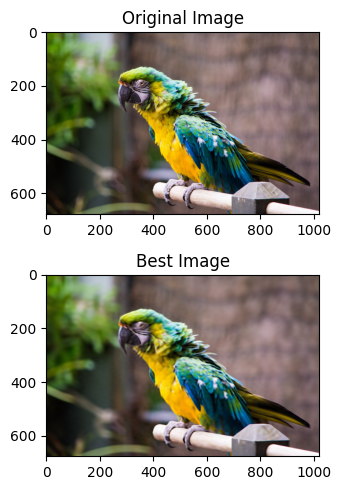

In [ ]:
original = mat_file['get']
best_img = mat_file['rec']

plt.figure(figsize=(5, 5))
# First subplot
plt.subplot(2, 1, 1)  # 1 row, 2 columns, plot 1
plt.imshow(original, cmap='gray')  # Display the first image
plt.title('Original Image')  # Add a title

# Second subplot
plt.subplot(2, 1, 2)  # 1 row, 2 columns, plot 2
plt.imshow(best_img, cmap='gray')  # Display the second image
plt.title('Best Image')  # Add a title

print(f'PSNR for pixel jumbled: {utils.psnr(original, best_img)}')

# Show the figure
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()